In [30]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics

In [ ]:
spot_size_1 = 1
spot_size_2 = 10
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

In [54]:
adata_1_filter = sc.read_h5ad(r"D:\ppppaper\data\Result\ATAC_stereo_adata1.h5ad")
adata_1_filter.var_names_make_unique(join="++")
adata_1_filter

AnnData object with n_obs × n_vars = 4132 × 18339
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Aire', 'batch_name_idx', 'barcode', 'suffix', 'x1', 'x2', 'p1', 'p2', 'Barcodes', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'Barcodes_cut', 'slice_name', 'batch_name', 'mclust', 'target_celltype'
    uns: 'Spatial_Net', 'annotation_colors', 'batch_name_colors', 'mclust_colors', 'neighbors', 'target_celltype_colors', 'umap'
    obsm: 'SLAT', 'X_glue', 'X_seurat', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [55]:
adata_2_filter = sc.read_h5ad(r"D:\ppppaper\data\Result\ATAC_stereo_adata2.h5ad")
adata_2_filter.var_names_make_unique(join="++")
adata_2_filter

AnnData object with n_obs × n_vars = 2099 × 18339
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Aire', 'batch_name_idx', 'barcode', 'suffix', 'x1', 'x2', 'p1', 'p2', 'Barcodes', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'Barcodes_cut', 'slice_name', 'batch_name', 'mclust', 'target_celltype'
    uns: 'annotation_colors', 'batch_name_colors', 'mclust_colors', 'neighbors', 'target_celltype_colors', 'umap'
    obsm: 'X_glue', 'X_seurat', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [56]:
x1_coords=adata_1_filter.obsm['spatial'][:,0]
y1_coords=adata_1_filter.obsm['spatial'][:,1]
x2_coords=adata_2_filter.obsm['spatial'][:,0]
y2_coords=adata_2_filter.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [57]:
Cal_Spatial_Net(adata_1_filter, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata_2_filter, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 42976 edges, 4132 cells.
10.400774443368828 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 22057 edges, 2099 cells.
10.508337303477846 neighbors per cell on average.


In [58]:
edges, features = load_anndatas([adata_1_filter, adata_2_filter], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [59]:
embd2, embd3, norm0, norm1, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 17.91


In [60]:
adata_2_filter.obs['annotation'] = adata_2_filter.obs['Clusters']
adata_1_filter.obsm['SLAT'] = embd2.detach().cpu().numpy()
adata_2_filter.obsm['SLAT'] = embd3.detach().cpu().numpy()
adata_com_2 = sc.concat([adata_1_filter,adata_2_filter], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com_2, use_rep= 'SLAT')
sc.tl.umap(adata_com_2)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


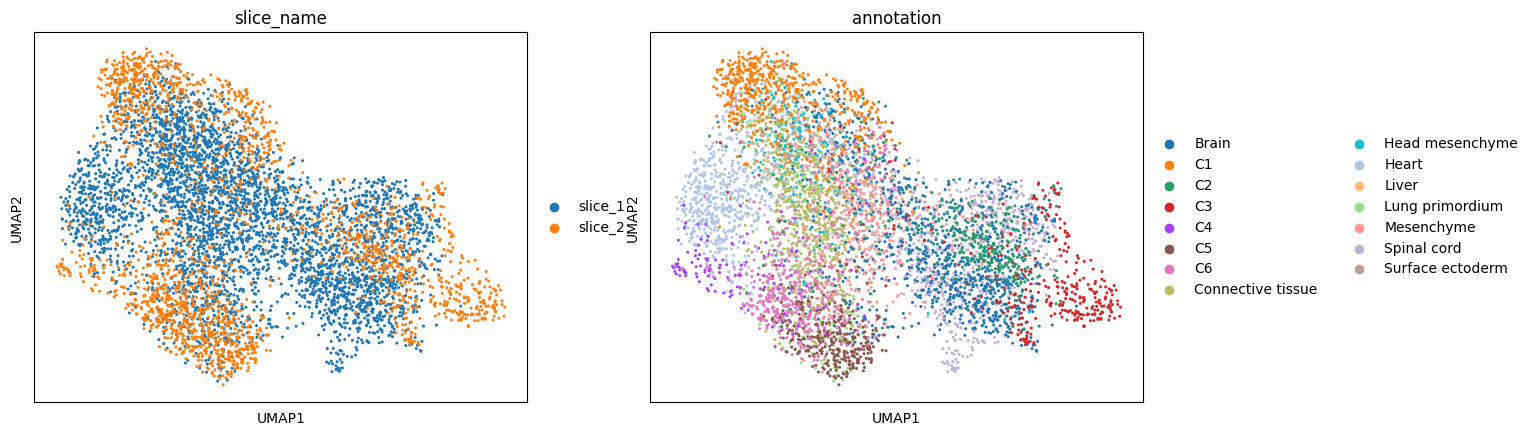

In [61]:
sc.pl.umap(adata_com_2, color= ['slice_name', 'annotation'])

In [62]:
best, index, distance = spatial_match([embd2, embd3], adatas=[adata_1_filter, adata_2_filter])
adata1_df = pd.DataFrame({'index': range(embd2.shape[0]),
                        'x': adata_1_filter.obsm['spatial'][:,0],
                        'y': adata_1_filter.obsm['spatial'][:,1],
                        'celltype': adata_1_filter.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd3.shape[0]),
                        'x': adata_2_filter.obsm['spatial'][:,0],
                        'y': adata_2_filter.obsm['spatial'][:,1],
                        'celltype': adata_2_filter.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [63]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values

max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels

adata_2_filter.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

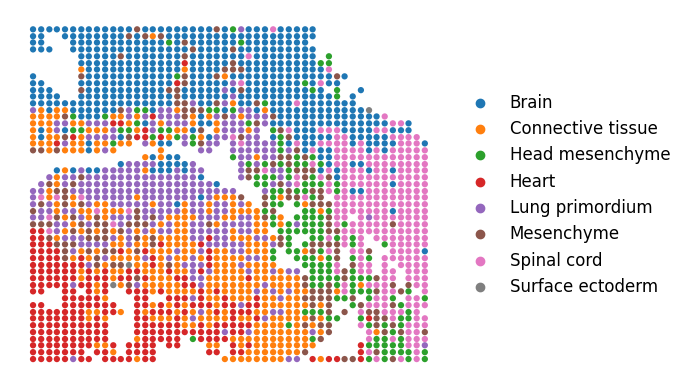

In [64]:
sc.pl.spatial(adata_2_filter, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size_2)

In [ ]:
# adata_1_filter.write('D:\ppppaper\data\Result\ATAC_stereo_SLAT_adata1.h5ad')

In [ ]:
# adata_2_filter.write('D:\ppppaper\data\Result\ATAC_stereo_SLAT_adata2.h5ad')

In [70]:
from scSLAT.viz import match_3D_multi, hist, match_3D_celltype, build_3D

In [71]:
atac_score = pd.read_csv(r"D:\WeChat\WeChat Files\wxid_blfvg4sns2ju22\FileStorage\File\2025-02\ArchR_impute_score.csv", index_col=0).T
atac_score['barcodes'] = atac_score.index.str.split('-').str[0].str.split('#').str[1]
atac = sc.read_h5ad(r"D:\ppppaper\data\ATAC_stereo\Mouse_embryo_ME11_20um_ATAC_seq.h5ad")
atac.obs['barcodes'] = atac.obs['Barcodes'].str.split('-').str[0].str.split('#').str[1]
merged_df = pd.merge(atac.obs, atac_score, on = 'barcodes', suffixes = ('_left', '_right'))
merged_df.index = merged_df.barcode
atac.obs = merged_df

In [72]:
adata2_df['Tnnt2'] = sc.get.obs_df(atac, 'Tnnt2').values
adata1_df['Tnnt2'] = sc.get.obs_df(adata_1_filter, 'Tnnt2').values

In [73]:
import seaborn as sns
cmap = sns.light_palette("orange", n_colors=200, as_cmap=True)

dataset1: 9 cell types; dataset2: 6 cell types; 
                    Total :15 celltypes; Overlap: 0 cell types 
                    Not overlap :[['Brain', 'Lung primordium', 'Liver', 'Heart', 'Head mesenchyme', 'Spinal cord', 'Mesenchyme', 'Connective tissue', 'Surface ectoderm', 'C1', 'C3', 'C6', 'C5', 'C2', 'C4']]
Subsampled 2098 pairs from 2099


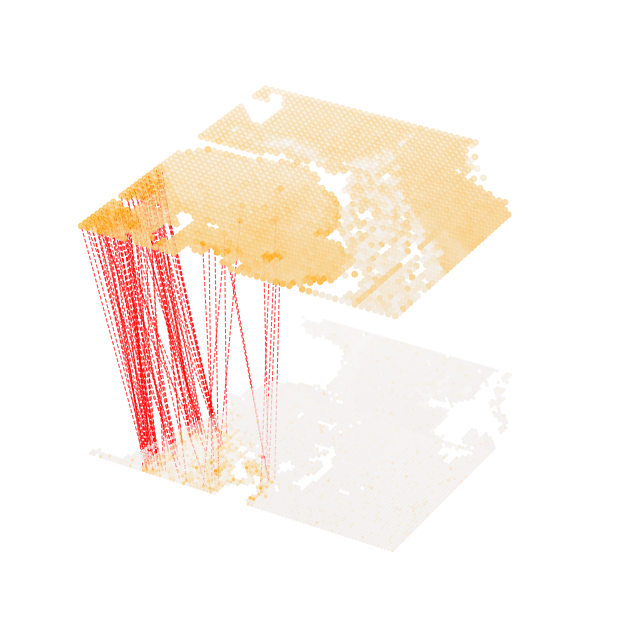

In [76]:
test = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype=[['Heart'],['C4']], expr='Tnnt2',rotate=['y','y'],
                         subsample_size = matching.shape[1]-1, scale_coordinate=True)
test.draw_3D(size=[8, 8], line_width=0.8, point_size=[3,15], hide_axis=True, cmap = cmap, show_error=False)